In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
train_data=image_dataset_from_directory(
    r"..\data\retina\train",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 76515 files belonging to 4 classes.


In [4]:
valid_data=image_dataset_from_directory(
    r"..\data\retina\val",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 21861 files belonging to 4 classes.


In [5]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [6]:
INPUT_SHAPE=(224, 224, 3)

In [7]:
mobile_net=tf.keras.applications.MobileNetV3Large(
    input_shape=INPUT_SHAPE,
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
)

In [8]:
model=tf.keras.models.Sequential()

In [9]:
model.add(tf.keras.Input(shape=INPUT_SHAPE))

In [10]:
model.add(mobile_net)

In [11]:
model.add(tf.keras.layers.Dense(units=4,activation="softmax"))

In [13]:
import tensorflow as tf
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = K.argmax(y_pred, axis=-1)
        y_true = K.argmax(y_true, axis=-1)

        # Calculate true positives, false positives, and false negatives
        tp = K.sum(K.cast(K.equal(y_true, y_pred), K.floatx()))
        fp = K.sum(K.cast(K.equal(y_true, 0) & K.not_equal(y_pred, y_true), K.floatx()))
        fn = K.sum(K.cast(K.equal(y_pred, 0) & K.not_equal(y_true, y_pred), K.floatx()))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        return f1

    def reset_states(self):
        # Reset all variables at the end of each epoch
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=['accuracy', F1Score()])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 1000)             5507432   
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 4004      
                                                                 
Total params: 5,511,436
Trainable params: 5,487,036
Non-trainable params: 24,400
_________________________________________________________________


In [17]:
training_history=model.fit(x=train_data,validation_data=valid_data,epochs=20,verbose=1)

Epoch 1/20
2391/2392 [============================>.] - ETA: 0s - loss: 1.1312 - accuracy: 0.8828 - f1_score: 0.9547

c:\Users\yashr\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2392/2392 [==============================] - 301s 122ms/step - loss: 1.1312 - accuracy: 0.8828 - f1_score: 0.9547 - val_loss: 0.9740 - val_accuracy: 0.8963 - val_f1_score: 0.9616
Epoch 2/20
2392/2392 [==============================] - 330s 138ms/step - loss: 0.8578 - accuracy: 0.8977 - f1_score: 0.9575 - val_loss: 0.7628 - val_accuracy: 0.8976 - val_f1_score: 0.9594
Epoch 3/20
2392/2392 [==============================] - 314s 131ms/step - loss: 0.6724 - accuracy: 0.8961 - f1_score: 0.9692 - val_loss: 0.5794 - val_accuracy: 0.8994 - val_f1_score: 0.9824
Epoch 4/20
2392/2392 [==============================] - 312s 130ms/step - loss: 0.5197 - accuracy: 0.8944 - f1_score: 0.9836 - val_loss: 0.4525 - val_accuracy: 0.8936 - val_f1_score: 0.9862
Epoch 5/20
2392/2392 [==============================] - 312s 131ms/step - loss: 0.4089 - accuracy: 0.9529 - f1_score: 0.9868 - val_loss: 0.3687 - val_accuracy: 0.9576 - val_f1_score: 0.9864
Epoch 6/20
2392/2392 [==============================] - 331s 

In [18]:
model.save("./trained_retinal_model_v2.h5")

In [19]:
training_history.history

{'loss': [1.1311975717544556,
  0.8578396439552307,
  0.672391414642334,
  0.5196840763092041,
  0.40891024470329285,
  0.325285404920578,
  0.2543480396270752,
  0.20159165561199188,
  0.15961873531341553,
  0.12861959636211395,
  0.10819680988788605,
  0.08971944451332092,
  0.07746531814336777,
  0.06663305312395096,
  0.058386046439409256,
  0.05355527997016907,
  0.05005393549799919,
  0.044560857117176056,
  0.04106131196022034,
  0.03866562247276306],
 'accuracy': [0.8827811479568481,
  0.8976671099662781,
  0.8961118459701538,
  0.8944259285926819,
  0.9528981447219849,
  0.9621642827987671,
  0.9685028791427612,
  0.9735084772109985,
  0.9782787561416626,
  0.9817683100700378,
  0.9832059144973755,
  0.986015796661377,
  0.9872835278511047,
  0.9889956116676331,
  0.990250289440155,
  0.9906293153762817,
  0.9910605549812317,
  0.9922367930412292,
  0.9926419854164124,
  0.9930340647697449],
 'f1_score': [0.9547204971313477,
  0.9574623107910156,
  0.9691580533981323,
  0.9835

In [20]:
import pickle

In [21]:
with open("training_history_v2.pkl","wb") as f:
    pickle.dump(training_history.history,f)

In [22]:
with open("training_history_v2.pkl","rb") as f:
    load_history=pickle.load(f)
print(load_history)

{'loss': [1.1311975717544556, 0.8578396439552307, 0.672391414642334, 0.5196840763092041, 0.40891024470329285, 0.325285404920578, 0.2543480396270752, 0.20159165561199188, 0.15961873531341553, 0.12861959636211395, 0.10819680988788605, 0.08971944451332092, 0.07746531814336777, 0.06663305312395096, 0.058386046439409256, 0.05355527997016907, 0.05005393549799919, 0.044560857117176056, 0.04106131196022034, 0.03866562247276306], 'accuracy': [0.8827811479568481, 0.8976671099662781, 0.8961118459701538, 0.8944259285926819, 0.9528981447219849, 0.9621642827987671, 0.9685028791427612, 0.9735084772109985, 0.9782787561416626, 0.9817683100700378, 0.9832059144973755, 0.986015796661377, 0.9872835278511047, 0.9889956116676331, 0.990250289440155, 0.9906293153762817, 0.9910605549812317, 0.9922367930412292, 0.9926419854164124, 0.9930340647697449], 'f1_score': [0.9547204971313477, 0.9574623107910156, 0.9691580533981323, 0.9835798144340515, 0.9867705702781677, 0.9880021810531616, 0.990403950214386, 0.991969704

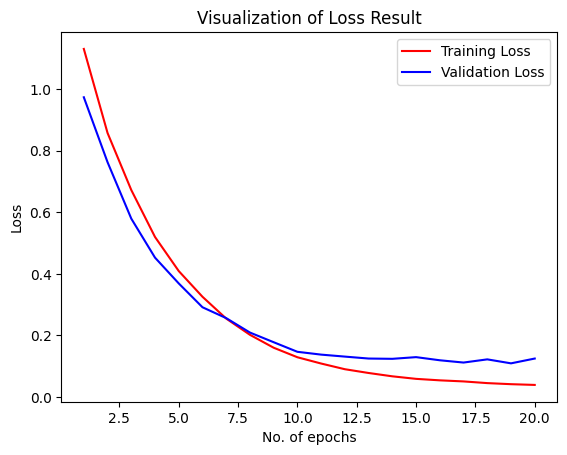

In [24]:
epochs = list(range(1, len(load_history['loss']) + 1))

plt.plot(epochs, load_history['loss'], color='red', label="Training Loss")
plt.plot(epochs, load_history['val_loss'], color='blue', label="Validation Loss")
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()


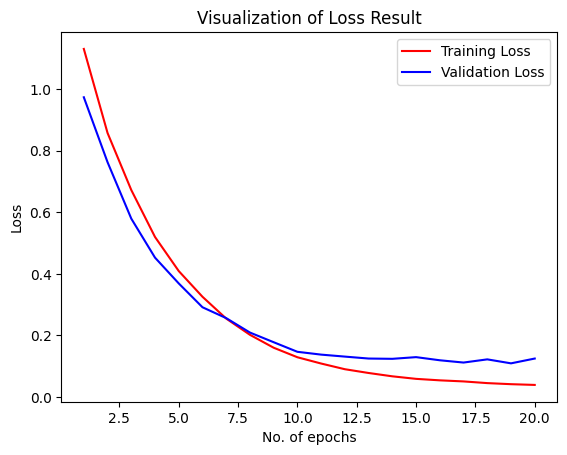

In [26]:
epochs=[i for i in range(1,21)]
plt.plot(epochs,load_history['loss'],color='red',label="Training Loss")
plt.plot(epochs,load_history['val_loss'],color='blue',label="Validation Loss")
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

In [28]:
from tensorflow.keras import backend as K
# Define the F1Score metric function (if you haven't defined it yet)
def f1_score(y_true, y_pred):
    # Calculate precision and recall
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    
    # Return the harmonic mean of precision and recall (F1 Score)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [31]:
model = tf.keras.models.load_model("trained_retinal_model_v2.h5", 
                   custom_objects={"F1Score": lambda name="f1_score", **kwargs: F1Score(name=name, **kwargs)})

In [37]:
# model=tf.keras.models.load_model("trained_retinal_model_v2.h5")

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 1000)             5507432   
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 4004      
                                                                 
Total params: 5,511,436
Trainable params: 5,487,036
Non-trainable params: 24,400
_________________________________________________________________


In [33]:
test_data=image_dataset_from_directory(
    r"..\data\retina\test",
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 10933 files belonging to 4 classes.


In [36]:
# test_loss,test_acc=model.evaluate(test_data)

In [35]:
test_loss, test_acc, f1_score = model.evaluate(test_data)


342/342 [==============================] - 11s 32ms/step - loss: 0.1327 - accuracy: 0.9682 - f1_score: 0.9896


In [40]:
true_categories=tf.concat([y for x,y in test_data],axis=0)
true_categories

<tf.Tensor: shape=(10933, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)>

In [41]:
y_true=tf.argmax(true_categories,axis=1)
y_true

<tf.Tensor: shape=(10933,), dtype=int64, numpy=array([0, 0, 0, ..., 3, 3, 3], dtype=int64)>

In [42]:
predicted_categories=model.predict(test_data)
predicted_categories

342/342 [==============================] - 11s 30ms/step


array([[0.9915895 , 0.00236201, 0.00416564, 0.00188291],
       [0.9915895 , 0.00236201, 0.00416564, 0.00188291],
       [0.9915895 , 0.00236201, 0.00416564, 0.00188291],
       ...,
       [0.00107945, 0.00178532, 0.00313082, 0.9940044 ],
       [0.00108306, 0.00179025, 0.00314055, 0.9939861 ],
       [0.00107943, 0.00178534, 0.00313023, 0.994005  ]], dtype=float32)

In [43]:
# Predict using the trained model
predicted_categories = model.predict(test_data)

# Now, you can apply tf.argmax to get the predicted class labels
y_pred = tf.argmax(predicted_categories, axis=1)


342/342 [==============================] - 10s 30ms/step


In [44]:
from sklearn.metrics import classification_report

In [45]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3746
           1       0.91      0.97      0.94      1161
           2       0.89      0.89      0.89       887
           3       0.99      0.99      0.99      5139

    accuracy                           0.97     10933
   macro avg       0.94      0.95      0.95     10933
weighted avg       0.97      0.97      0.97     10933



In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
cm=confusion_matrix(y_true,y_pred)
print(cm)

[[3609   62   68    7]
 [  17 1125    3   16]
 [  63    4  787   33]
 [   6   41   28 5064]]


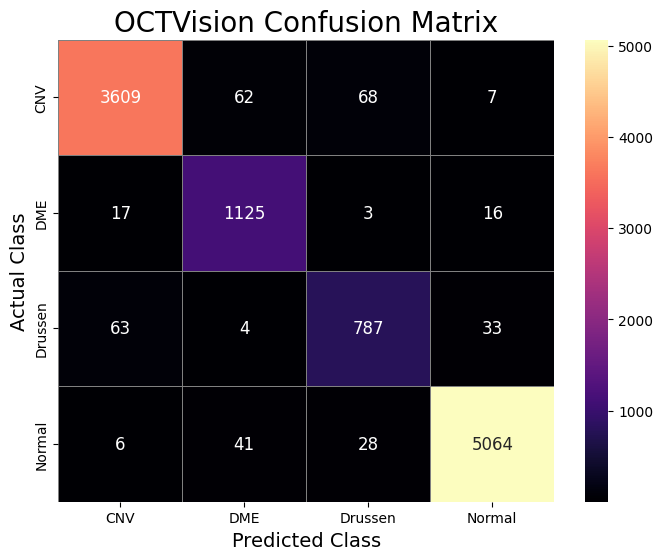

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Disease class names corresponding to the numeric labels
class_names = ['CNV', 'DME', 'Drussen', 'Normal']

# Assuming 'cm' is your confusion matrix
plt.figure(figsize=(8, 6))

# Define a color palette and add a color bar
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", annot_kws={"size": 12}, 
            cbar=True, linewidths=0.5, linecolor="gray", 
            xticklabels=class_names, yticklabels=class_names)

# Customize axis labels and title
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("Actual Class", fontsize=14)
plt.title("OCTVision Confusion Matrix", fontsize=20)

# # Adjust tick labels for better readability
# plt.xticks(rotation=45, fontsize=12)
# plt.yticks(rotation=45, fontsize=12)

# Set a grid for better cell division
plt.grid(False)

# Show plot
plt.show()


In [64]:
# plt.figure(figsize=(8,6))
# sns.heatmap(cm,annot=True,annot_kws={"size":8})
# plt.xlabel("Predicted Class",fontsize=10)
# plt.ylabel("Actual Class",fontsize=10)
# plt.title("OCTVision Confusion Matrix",fontsize=20)
# plt.show()